In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/My Drive/Dataset
!ls

Mounted at /content/drive
/content/drive/My Drive/Dataset
 20191002-items.csv     heart.csv
 20191002-reviews.csv   Housing.csv
'Air Quality.csv'       image_predict
'archive (10).zip'     'Lazada (bisa yok).ipynb'
 bestvalue	        model.png
 Car_Rates.csv	        New_York_cars.csv
 customer_data.csv      New_York_cars.gsheet
 data_stem1.csv        'Revisian3 - Copy.docx'
 data_stem2.csv         Rice_Image_Train_Validation_Test
 data_stem3.csv         rice_image.zip
 data_stem4.csv         satellite_image.zip
 diabetes.csv	        train.csv
'Heart Attack.csv'      untitled_project


In [ ]:
pip install split-folders

In [ ]:
import splitfolders
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import os
import zipfile
import splitfolders

def unzip(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Path ke file ZIP dan direktori tujuan ekstraksi
zip_file_path = "/content/drive/My Drive/Dataset/rice_image.zip"
extract_to_dir = "/tmp"

# Memanggil fungsi unzip untuk menginisialisasi proses ekstraksi
unzip(zip_file_path, extract_to_dir)

# Path ke direktori yang telah diekstraksi
extracted_dir = "/tmp/Rice_Image_Dataset"  # Ganti dengan path yang sesuai

# Path ke direktori output untuk data latih, validasi, dan pengujian
output_dir = "/tmp/Rice_Image_Train_Validation_Test"  # Ganti dengan path yang sesuai

# Membagi gambar menjadi data latih, validasi, dan pengujian
splitfolders.ratio(extracted_dir, output=output_dir, seed=42, ratio=(0.7, 0.2, 0.1), group_prefix=None)


Copying files: 75000 files [00:12, 5907.09 files/s]


In [ ]:
# read train, validation and test in dataset
BATCH_SIZE = 20

IMAGE_SIZE = (160, 160)

Train = keras.utils.image_dataset_from_directory(

    directory = '/tmp/Rice_Image_Train_Validation_Test/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    seed = 42,
)

Validation = keras.utils.image_dataset_from_directory(
    directory = '/tmp/Rice_Image_Train_Validation_Test/val',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    seed = 42,
)

Test = keras.utils.image_dataset_from_directory(
    directory = '/tmp/Rice_Image_Train_Validation_Test/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    seed = 42,
)

Found 52500 files belonging to 5 classes.
Found 15000 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.


In [ ]:
for i in [Train, Validation, Test]:
    class_names = i.class_names
    print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


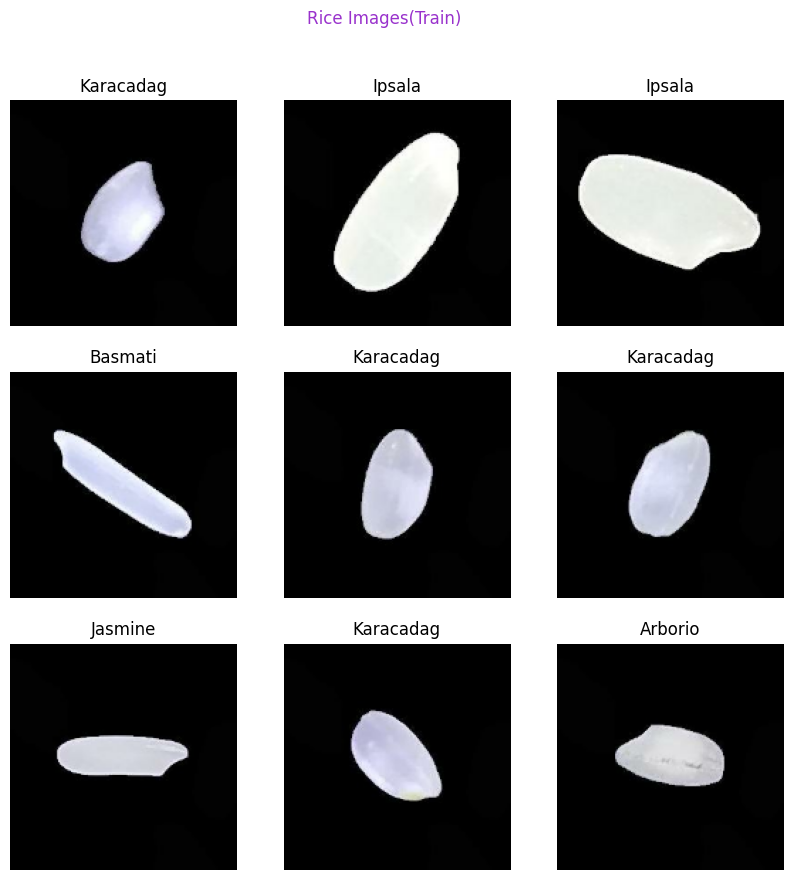

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in Train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint32"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.suptitle('Rice Images(Train)', y=0.97, color='darkorchid')
plt.show()

In [ ]:
import tensorflow.keras.models as Models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2

# **Augmentation**

In [ ]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.2,
      zoom_range=0.5,
      horizontal_flip=True,
      fill_mode='nearest')

image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory='/tmp/Rice_Image_Train_Validation_Test/train',
                                                     shuffle=True,
                                                     target_size=IMAGE_SIZE,
                                                     class_mode='categorical')

Found 52500 images belonging to 5 classes.


In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory='/tmp/Rice_Image_Train_Validation_Test/val',
                                                 target_size=IMAGE_SIZE,
                                                 class_mode='categorical')

Found 15000 images belonging to 5 classes.


In [ ]:
# Dapatkan kamus yang memetakan antara indeks kelas dan nama kelas
class_mapping = train_data_gen.class_indices

# Tampilkan nama-nama kelas
class_name = list(class_mapping.keys())
print("Class names:", class_name)

Class names: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

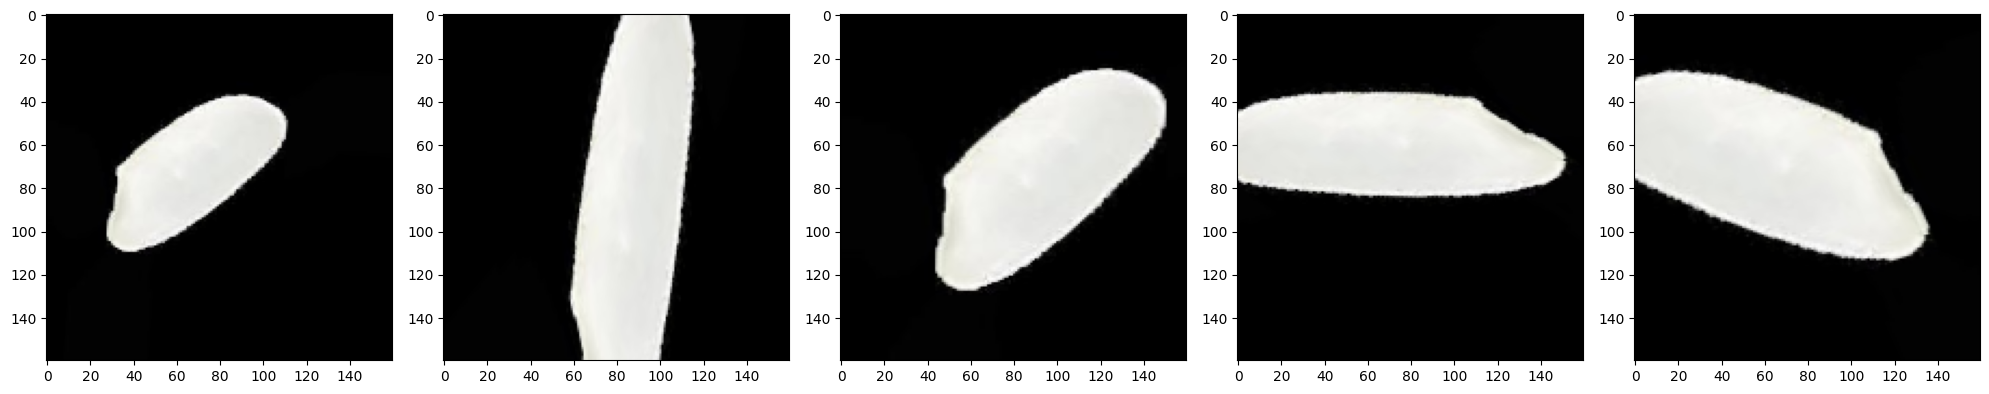

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
model = Models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(160,160,3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

In [ ]:
history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=35,
    callbacks=callback_list
)

# **Tanpa Augmentation**

In [ ]:
model = Models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(160,160,3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
history = model.fit(x=Train, validation_data= Validation, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2625/2625 [==============================] - 78s 29ms/step - loss: 11.5636 - accuracy: 0.9483 - val_loss: 0.1810 - val_accuracy: 0.9779
Epoch 2/10
2625/2625 [==============================] - 73s 28ms/step - loss: 0.1033 - accuracy: 0.9806 - val_loss: 0.1089 - val_accuracy: 0.9716
Epoch 3/10
2625/2625 [==============================] - 75s 29ms/step - loss: 0.0386 - accuracy: 0.9872 - val_loss: 0.1138 - val_accuracy: 0.9734
Epoch 4/10
2625/2625 [==============================] - 73s 28ms/step - loss: 0.0326 - accuracy: 0.9899 - val_loss: 0.1440 - val_accuracy: 0.9741
Epoch 5/10
2625/2625 [==============================] - 73s 28ms/step - loss: 0.0344 - accuracy: 0.9897 - val_loss: 0.1192 - val_accuracy: 0.9793
Epoch 6/10
2625/2625 [==============================] - 73s 28ms/step - loss: 0.0213 - accuracy: 0.9937 - val_loss: 0.1057 - val_accuracy: 0.9800
Epoch 7/10
2625/2625 [==============================] - 76s 29ms/step - loss: 0.0250 - accuracy: 0.9952 - val_loss: 0.1236 - val_accur

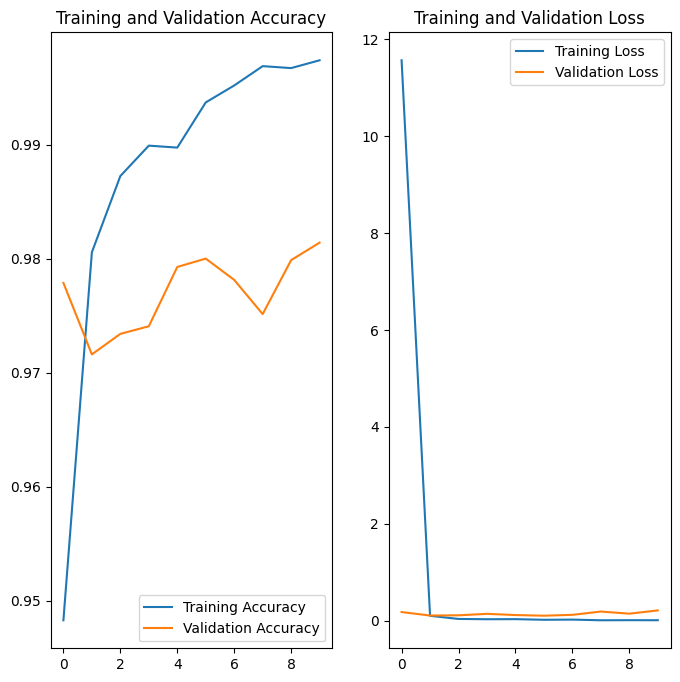

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Prediksi**

In [ ]:
for images, labels in Test:
    test_labels = labels
    predictions = tf.nn.softmax(model(images))
    test_images = images
    break

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    """
    For plot each image
        i (int): image number
        predictions_array (tensor): prediction for input_image
        ture_label (tensor): true label for input_image
        img (tensor): input_image
    """

    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.numpy().astype("uint8"))
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'black'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    """
    Plot bar plot of predciton
        i (int): image number
        predictions_array (tensor): prediction array of image
        ture_label (tensor): true label for image
    """

    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(5))
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('black')

def plot_final_result(predictions_array, test_labels, test_images, num_rows=10, num_cols=3):
    """
    Plot the first X test images, their predicted labels, and the true labels.
        predictions_array(): all predictions for all test_image
        test_labels(): all true label for all test_image
        test_images(): all test_image
    """

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions_array[i], test_labels, test_images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions_array[i], test_labels)

    plt.tight_layout()
    plt.show()

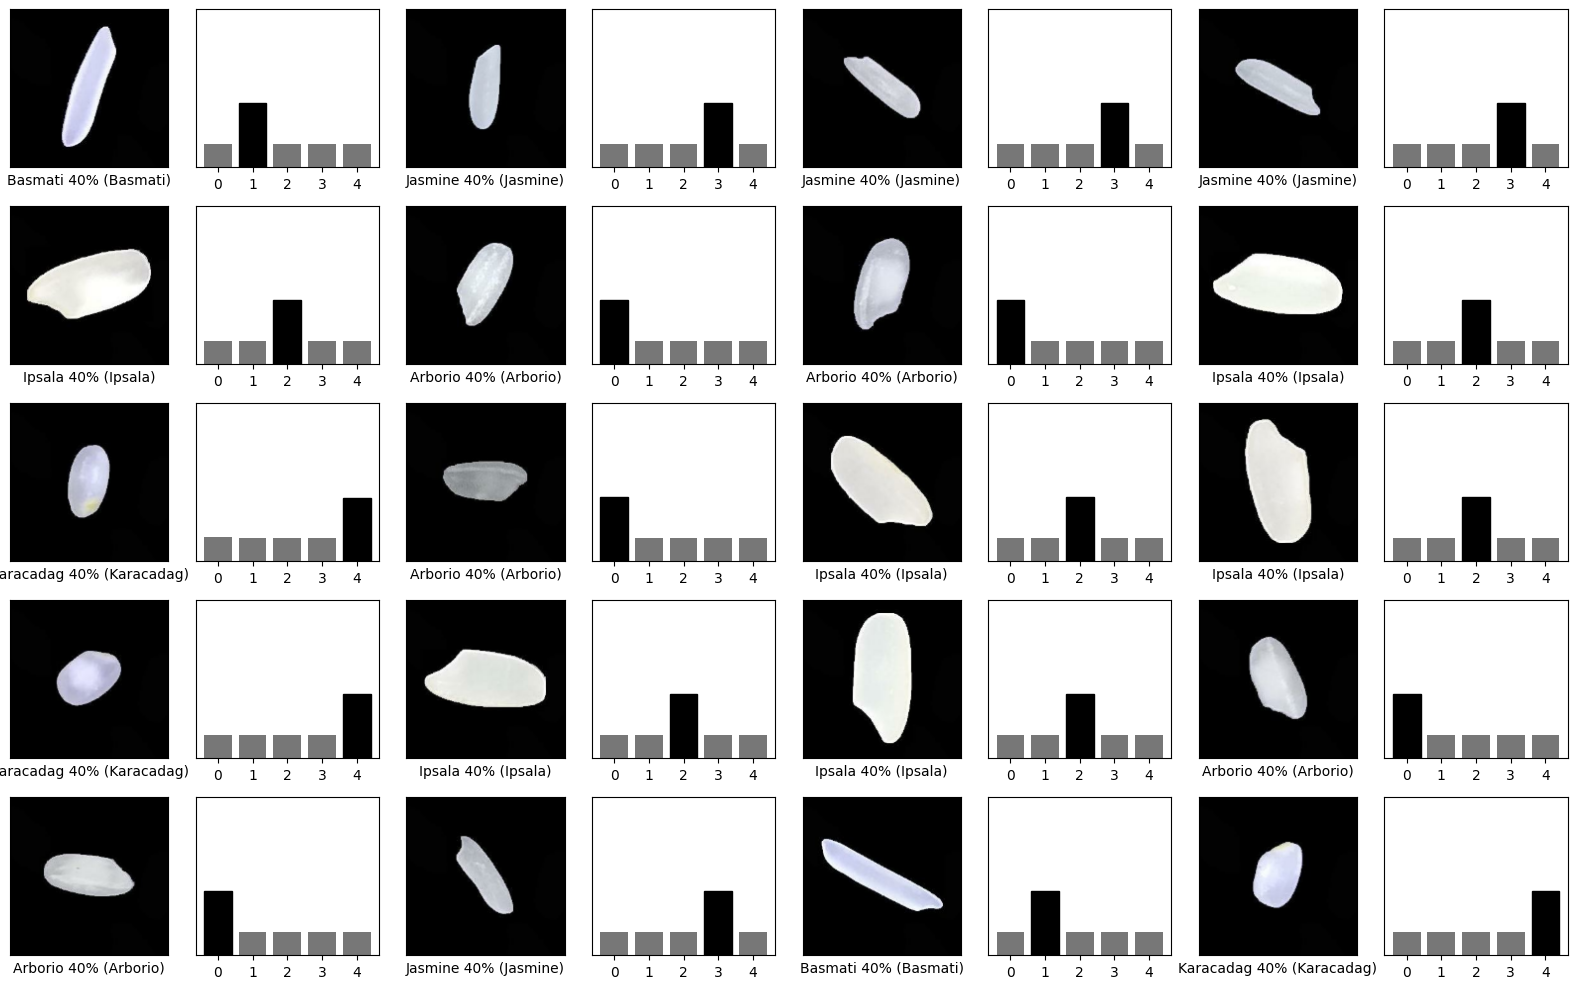

In [ ]:
plot_final_result(predictions, test_labels, test_images, num_rows=5, num_cols=4)

# **Save Model**

In [ ]:
# model.save("/content/drive/My Drive/model_rice.h5")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Muat model dari file
loaded_model = load_model("/content/drive/My Drive/model_rice.h5")

In [ ]:
def predict_img(path_image):
  img_path = path_image
  img = image.load_img(img_path, target_size=(160, 160))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.

  prediction = loaded_model.predict(img_array)

  predicted_class = np.argmax(prediction)

  class_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
  predicted_class_name = class_names[predicted_class]

  # Display the image and prediction label
  plt.imshow(img)
  plt.title(predicted_class_name)
  plt.show()

1/1 [==============================] - 10s 10s/step


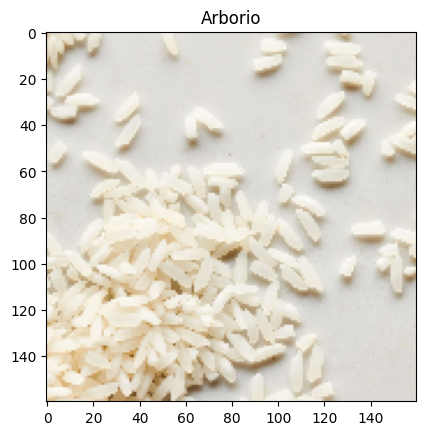

In [ ]:
predict_img("/content/drive/My Drive/Dataset/image_predict/Rice_Image/jasmine/jasmine_2.jpeg")

In [ ]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 79, 79, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 199712)            0         
                                                                 
 dense_3 (Dense)             (None, 320)               63908160  
                                                                 
 dense_4 (Dense)             (None, 5)                 1605      
                                                                 
Total params: 63,910,661
Trainable params: 63,910,661
Non-trainable params: 0
__________________________________________